this notebook contains different methods through we can create a Machine Learning/Deep Learning model that can classify whether the text is Human written or ai written

1. first one is using machine learning approach
2. using deep learning approach
3. in deep learning approach we will try two methods first is to create a lstm neural network with attention mechanism second we will fine tune a transformer to predict whether the given sentence is AI generated or human generated.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
import re
import string
from nltk.corpus import stopwords
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix

loading dataset

In [2]:
dataset = pd.read_csv("D:\Datasets\AI_Human.csv")

dataset.head()

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [15]:
dataset = dataset.iloc[:20000,:]

In [16]:
# shape of the dataset

dataset.shape

(20000, 2)

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       20000 non-null  object 
 1   generated  20000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 312.6+ KB


In [18]:
# finding null value

dataset.isna().sum()

text         0
generated    0
dtype: int64

<Axes: >

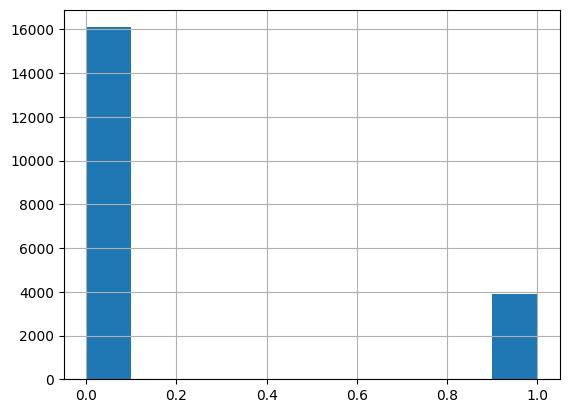

In [19]:
# classes in the dataset

dataset['generated'].unique()

dataset['generated'] = dataset['generated'].astype(int)

dataset['generated'].hist()

In [20]:
sample_data = pd.DataFrame(dataset['text'][:5])

Cleaning the data

In [21]:
# tags = ['\n','\'']
# punctuations = string.punctuation

# def data_cleaning(sentence):
#     sentence = sentence.lower() # lowercasing the sentence
#     for tag in tags:
#         sentence = sentence.replace(tag,'') # replacing tags
#     sentence = [x for x in sentence if x not in punctuations] # removing punctuations
#     sentence = ''.join(sentence)
#     # removing stopwords
#     sentence = nltk.word_tokenize(sentence)
#     sentence = [sent for sent in sentence if sent not in set(stopwords.words('english'))]
#     sentence = ' '.join(sentence) 
#     return sentence

# dataset['text'] = dataset['text'].apply(data_cleaning)

# dataset.to_csv("cleaned_data.csv")


In [2]:
dataset_n = pd.read_csv("cleaned_data.csv")

In [3]:
dataset_n.head()

,Unnamed: 0.1,Unnamed: 0,text,generated
0,0,0,cars cars around since became famous 1900s hen...,0
1,1,1,transportation large necessity countries world...,0
2,2,2,americas love affair vehicles seems cooling sa...,0
3,3,3,often ride car drive one motor vehicle work st...,0
4,4,4,cars wonderful thing perhaps one worlds greate...,0


In [7]:
dataset_n.dropna(inplace=True, axis=0)

Creating Model for Data classification

In [25]:
# Splitting dataset into train, test set

x = dataset['text']

y = dataset['generated']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [26]:
pipeline_nb = Pipeline([('CountVectorizer', CountVectorizer()),
                        ('Tfidf_Transformer',TfidfTransformer()),
                        ("Miltinomial Naive Bayes Classifier",MultinomialNB())])

pipeline_nb.fit(x_train,y_train)

Pipeline(steps=[('CountVectorizer', CountVectorizer()),
                ('Tfidf_Transformer', TfidfTransformer()),
                ('Miltinomial Naive Bayes Classifier', MultinomialNB())])

In [29]:
y_pred = pipeline_nb.predict(x_test)


score = accuracy_score(y_true=y_test,y_pred=y_pred)

cm = confusion_matrix(y_true=y_test,y_pred=y_pred)

print(cm)

[[3229    0]
 [ 458  313]]


# Using Neural Network to solve the problem

In [2]:
from keras.layers import Input,Dense,LSTM,Embedding
from keras.models import Model
import contractions
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from utils.attention import AttentionLayer
import tensorflow as tf
from keras.utils import plot_model

In [3]:
dataset_n = pd.read_csv("cleaned_data2.csv")

Text preprocessing

In [6]:
# def preprocess(text):
#     text =  text.lower()
#     text = [contractions.fix(word) for word in text.split(" ")]
#     text = " ".join(text)
#     text = [word for word in text.split() if word not in stopwords.words('english')]
#     text = " ".join(text)
#     text = re.sub(r"\'s","",text) # remove 's from the sentence
#     text = re.sub(r"\(.*\)","",text)
#     text = re.sub("[^A-Za-z0-9.]"," ",text) # remove punctuations from the sentence
#     text = re.sub(r'\.','. ',text)
#     text = re.sub(r"\s+"," ",text)
#     return text


# dataset_n['text'] = dataset_n['text'].apply(preprocess)

In [7]:
# dataset_n.to_csv("cleaned_data2.csv")

In [4]:
# calculating the maximum len of sentence

max_len = max([len(sent.split()) for sent in dataset_n['text']])

print(max_len)

879


In [5]:
# Splitting dataset into train, test set

x = dataset_n['text']

y = dataset_n['generated']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

Creating a embedding matrix

In [6]:
# we will be using glove dictionary to embed the text and then pass it to our lstm neural network

GLOVE_PATH = r"D:\Datasets\glove\glove.42B.300d.txt\glove.42B.300d.txt"

embedding_dictionary = {}

with open(GLOVE_PATH,'r',encoding='utf-8') as file:
    for line in file:
            values =  line.split()
            word = values[0]
            vector = np.array(values[1:],'float32')
            embedding_dictionary[word] = vector

Gathering some information from the dataset

In [12]:
# total words in the corpus
corpus = set()

embedding_dictionary_words = set(embedding_dictionary.keys())

for sentence in dataset_n['text']:
    for word in sentence.split():
        if word not in corpus:
            corpus.add(word)

# intersecting words
intersecting_words = corpus & embedding_dictionary_words
print(f"Percentage of words present in the embedding dictionary that are also present in the corpus are {(len(intersecting_words)/len(corpus))*100} %")

Percentage of words present in the embedding dictionary that are also present in the corpus are 43.25943460645514 %


Tokenization

In [11]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(dataset_n['text'])

vocab_size = len(tokenizer.word_index) + 1

x_train_sequence = tokenizer.texts_to_sequences(x_train)
x_test_sequence = tokenizer.texts_to_sequences(x_test)
x_val_sequence = tokenizer.texts_to_sequences(x_val)

padded_X_train = pad_sequences(sequences=x_train_sequence,maxlen=max_len,padding='post')
padded_X_test = pad_sequences(sequences=x_test_sequence,maxlen=max_len,padding='post')
padded_X_val = pad_sequences(sequences=x_val_sequence,maxlen=max_len,padding='post')

In [12]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size,embedding_dim),dtype=np.float32)

for word,i in tokenizer.word_index.items():
    embedding_vector = embedding_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Developing neural network

here we will be creating a neural network that could use self-attention mechanism to predict whether the given text is human written or AI generated

In [22]:
input_layer = Input(shape=(max_len,),name="input_layer")

embedding_layer = Embedding(input_dim=vocab_size,output_dim=300,input_length=max_len,weights=[embedding_matrix],trainable=False,name="embedding_layer")(input_layer)

lstm_1,h1,c1 = LSTM(256,return_sequences=True,return_state=True,activation='relu',name="lstm_1")(embedding_layer)
lstm_2,h2,c2 = LSTM(256,return_sequences=True,return_state=True,activation='relu',name="lstm_2")(lstm_1)

# implementing attention Mechanism
attention,attention_states = AttentionLayer(name="attention_layer")([lstm_2,lstm_2])

context_vector = tf.reduce_sum(attention,axis=1,name="context_sum")

dense_layer = Dense(units=1,activation='softmax',name="dense_layer")(context_vector)


model = Model(input_layer,dense_layer)

In [23]:
plot_model(model,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 879)]                0         []                            
                                                                                                  
 embedding_layer (Embedding  (None, 879, 300)             3295080   ['input_layer[0][0]']         
 )                                                        0                                       
                                                                                                  
 lstm_1 (LSTM)               [(None, 879, 256),           570368    ['embedding_layer[0][0]']     
                              (None, 256),                                                        
                              (None, 256)]                                                  

In [25]:
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=['accuracy'])

In [26]:
model.fit(x=padded_X_train,y=y_train, batch_size=32, epochs = 100,validation_data=(padded_X_val,y_val),verbose=1)

Epoch 1/100




# Fine Tunning HuggingFace transformer to classify text as human or AI generated

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torchinfo import summary
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments,pipeline

c:\Users\Omen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = pd.read_csv("cleaned_data3.csv")

dataset.drop(columns=["Unnamed: 0"],axis=1,inplace=True)

Developing Target map

In [4]:
dataset.head()

,text,labels
0,cars cars around since became famous 1900s hen...,0
1,transportation large necessity countries world...,0
2,americas love affair vehicles seems cooling sa...,0
3,often ride car drive one motor vehicle work st...,0
4,cars wonderful thing perhaps one worlds greate...,0


In [5]:
dataset.isna().sum()

text      0
labels    0
dtype: int64

In [6]:
dataset.rename(columns={'generated':'labels'},inplace=True)

In [7]:
dataset.head()

,text,labels
0,cars cars around since became famous 1900s hen...,0
1,transportation large necessity countries world...,0
2,americas love affair vehicles seems cooling sa...,0
3,often ride car drive one motor vehicle work st...,0
4,cars wonderful thing perhaps one worlds greate...,0


array([[<Axes: title={'center': 'labels'}>]], dtype=object)

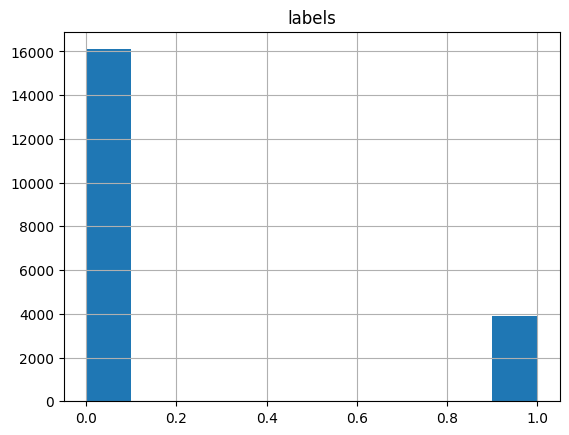

In [8]:
dataset.hist()

data here is not so good because only 10000 instances were taken

In [9]:
dataset.to_csv("cleaned_data3.csv")

In [10]:
dataset = load_dataset("csv", data_files="cleaned_data3.csv")

dataset

Generating train split: 19999 examples [00:00, 38136.66 examples/s]


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'labels'],
        num_rows: 19999
    })
})

In [11]:
split = dataset['train'].train_test_split(test_size=0.3,seed=42)

split

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'labels'],
        num_rows: 13999
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'labels'],
        num_rows: 6000
    })
})

Tokenization

In [12]:
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
def tokenizer_function(batch):
    return tokenizer(batch['text'],truncation=True)

tokenized_dataset = split.map(tokenizer_function,batched=True)

Map: 100%|██████████| 6000/6000 [00:01<00:00, 3139.09 examples/s]


In [16]:
# defining pretrained model

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

In [18]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64)

In [19]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [20]:
trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

In [22]:
trainer.train()